# Regression: Nonlinear Models

Cameron White <br/>
March 30, 2020

### Contents

1&nbsp; Refresher on Regression <br/>
&nbsp;&nbsp; 1.1&nbsp; Linear vs. Nonlinear Models <br/>
2&nbsp; Nonlinear Regression <br/>
&nbsp;&nbsp; 2.1&nbsp; Levenberg–Marquardt Algorithm <br/>
3&nbsp; Uncertainties in the Data <br/>
&nbsp;&nbsp; 3.1&nbsp; Uncertainties in the Dependent and Independent Axes <br/>
4&nbsp; Regression that is Robust to Outliers <br/>
&nbsp;&nbsp; 4.1&nbsp; Huber Loss Function <br/>
&nbsp;&nbsp; 4.2&nbsp; Bayesian Outlier Methods <br/>

## 1. Refresher on Regression

### What is Regression?

Regression is defined as the relation between a dependent variable, y, and a set of independent variables, x, that describes the expectation value of y given x (the conditional expectation value).
<br/><br/>
We can define several types of regression based on three different classification axes:
1. Linearity: when a parametric model is linear in all model parameters
2. Problem complexity: A large number of independent variables increases the complexity of the error covariance matrix, and can become a limiting factor in nonlinear regression.
3. Error behavior: The uncertainties in the values of independent and dependent variables, and their correlations, are the primary factor that determines which regression method to use

### Linear vs. Nonlinear Models

Linear parametric models are those which have a linear dependence on their set of parameters, $\theta$. i.e.,
<br/><br/>
$f(x|\theta)=\sum_{p=1}^{k}\theta_pg_p(x)$.
<br/><br/>
Note that the models themselves do _not_ necessarily need to be linear in their independent variables. $g_p(x)$ could itself be a non-linear function. Examples of linear and non-linear parametric models are listed below:
<br/><br/>
$f(x|\theta) = \theta_1+\theta_2x$ (linear)
<br/><br/>
$f(x|\theta) = \theta_1\sin(x)+\theta_2\cos(x)$ (linear)
<br/><br/>
$f(x|\theta) = \theta_1\sin(\theta_2x)$ (nonlinear)


### 2. Nonlinear Regression

Let us return to the cosmology example introduced in the previous lecture in which we looked at linear regression techniques to fit a set of supernova distance moduli and their redshifts:

<img src="lecture13_files/lin_regression.png" style="width:60%">

### 2. Nonlinear Regression

<img src="lecture13_files/pc_regression.png" style="width:70%">

The true underlying model used to generate these data is in fact nonlinear in its parameters! In particular, this model is characterized by three cosmological parameters: $H_0$, $\Omega_m$, and $\Omega_{\Lambda}$, where the distance moduli are calculated as follows:

$$ \mu(z) = -5\log_{10}\left( (1+z)\frac{c}{H_0}\int\frac{dz}{(\Omega_m(1+z)^3+\Omega_{\Lambda})^{1/2}} \right). $$

### 2. Nonlinear Regression

For this example, we'll assume that $H_0$ is known and is equal to 70 km/s/Mpc. Solving for the remaining two parameters, $\Omega_{m}$ and $\Omega_{\Lambda}$, becomes a nonlinear optimization problem in which we must maximize the posterior:

$$ p(\Omega_{m},\Omega_{\Lambda}|z,I) \propto \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi}\sigma_i}\exp\left(\frac{-(\mu_i-\mu(z_i|\Omega_{m},\Omega_{\Lambda}))^2}{2\sigma_i^2}\right)p(\Omega_{m},\Omega_{\Lambda}). $$

This can be maximized using sampling routines such as the Metropolis-Hastings MCMC algorithm (see Jiachuan's lecture from February for an introduction!).

In [15]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from astropy.cosmology import LambdaCDM

from astroML.datasets import generate_mu_z
from astroML.plotting.mcmc import convert_to_stdev
from astroML.utils.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Generate the data
z_sample, mu_sample, dmu = generate_mu_z(100, z0=0.3,
                                         dmu_0=0.05, dmu_1=0.004,
                                         random_state=1)


#------------------------------------------------------------
# define a log likelihood in terms of the parameters
#  beta = [omegaM, omegaL]
def compute_logL(beta):
    cosmo = LambdaCDM(H0=71, Om0=beta[0], Ode0=beta[1], Tcmb0=0)
    mu_pred = cosmo.distmod(z_sample).value
    return - np.sum(0.5 * ((mu_sample - mu_pred) / dmu) ** 2)


#------------------------------------------------------------
# Define a function to compute (and save to file) the log-likelihood
@pickle_results('mu_z_nonlinear.pkl')
def compute_mu_z_nonlinear(Nbins=50):
    omegaM = np.linspace(0.05, 0.75, Nbins)
    omegaL = np.linspace(0.4, 1.1, Nbins)

    logL = np.empty((Nbins, Nbins))

    for i in range(len(omegaM)):
        for j in range(len(omegaL)):
            logL[i, j] = compute_logL([omegaM[i], omegaL[j]])

    return omegaM, omegaL, logL


omegaM, omegaL, res = compute_mu_z_nonlinear()
res -= np.max(res)

def plot():
    #------------------------------------------------------------
    # Plot the results
    fig = plt.figure(figsize=(5*1.6, 1.6*2.5))
    fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                        bottom=0.15, top=0.9)

    # left plot: the data and best-fit
    ax = fig.add_subplot(121)
    whr = np.where(res == np.max(res))
    omegaM_best = omegaM[whr[0][0]]
    omegaL_best = omegaL[whr[1][0]]
    cosmo = LambdaCDM(H0=71, Om0=omegaM_best, Ode0=omegaL_best, Tcmb0=0)

    z_fit = np.linspace(0.04, 2, 100)
    mu_fit = cosmo.distmod(z_fit).value

    ax.plot(z_fit, mu_fit, '-k')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray')

    ax.set_xlim(0, 1.8)
    ax.set_ylim(36, 46)

    ax.set_xlabel('$z$')
    ax.set_ylabel(r'$\mu$')

    ax.text(0.04, 0.96, "%i observations" % len(z_sample),
            ha='left', va='top', transform=ax.transAxes)

    # right plot: the likelihood
    ax = fig.add_subplot(122)

    ax.contour(omegaM, omegaL, convert_to_stdev(res.T),
               levels=(0.683, 0.955, 0.997),
               colors='k')

    ax.plot([0, 1], [1, 0], '--k')
    ax.plot([0, 1], [0.73, 0.73], ':k')
    ax.plot([0.27, 0.27], [0, 2], ':k')

    ax.set_xlim(0.05, 0.75)
    ax.set_ylim(0.4, 1.1)

    ax.set_xlabel(r'$\Omega_M$')
    ax.set_ylabel(r'$\Omega_\Lambda$')

    plt.show()

@pickle_results: using precomputed results from 'mu_z_nonlinear.pkl'


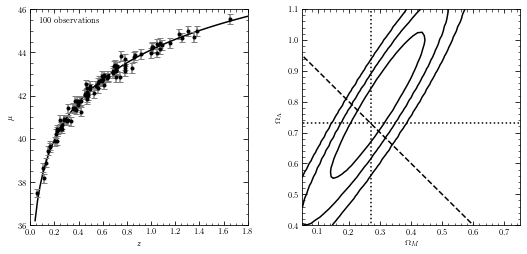

In [16]:
plot()

### 2.1 Levenberg–Marquardt (LM) Algorithm 

Alternatively, one could use the LM algorithm. This iterative procedure takes an initial guess for the parameter set and searches for minima in the $\chi^2$ surface using a combination of Gauss-Newton and gradient descent optimization. This assumes that the regression function can be written as a Taylor expansion:

$$ f(x_i|\mathbf{\theta}) = f(x_i|\mathbf{\theta_0}) + Jd\theta,\,\, J=\frac{\partial f(x_i|\theta)}{\partial\theta}, $$

where $d\theta$ represents a small perturbation in the parameter set. The goal is to then minimize the sum:

$$ \sum_i (y_i - f(x_i|\mathbf{\theta_0}) - Jd\theta)^2. $$

Thus, the work of LM primarily goes into finding $d\theta$ and updating the regression function at each step. $d\theta$ is solved for using the relation:

$$ (J^TC^{-1}J+\lambda\operatorname{diag}(J^TC^{-1}J))\,d\theta = J^TC^{-1}(Y-f(X|\theta)), $$

where $C$ is the covariance matrix and $\lambda$ is the so-called "damping parameter." The damping parameter acts as a sort of toggle between Gauss-Newton (small $\lambda$) and gradient-descent (large $\lambda$) algorithms. In general, $\lambda$ decreases as the minimum is approached.

### 2.1 Levenberg–Marquardt (LM) Algorithm 

While LM is an incredibly popular algorithm for nonlinear regression problems (see e.g. scipy.optimize.leastsq), it is important to note that it can be highly sensitive to the initial guesses. If there are various local minima within your parameter space, LM may get trapped and never reach the global minimum!

# 3. Uncertainties in the Data

Recall that regression is characterized by model complexity and error behavior. While we've explored model complexity in our linear vs. nonlinear discussions, up to this point we have been making a number of simplifying assumptions (e.g. Gaussian errors, negligible uncertainty in the independent variable, etc.). Unfortunately, we don't always have the luxury of making such assumptions about our data in good conscience.

We will now consider the cases of non-negligible errors in _both_ the dependent and independent variables.

## 3.1 Uncertainties in the Dependent and Independent Axes

In the vast majority of physical scenarios, the independent variables cannot be treated as error-free. For example, what if the supernova redshifts depicted in the earlier example were derived via their photometry as opposed to spectroscopy? This would introduce considerable error to their redshifts!

Error in the independent variable has the effect of biasing regression coefficients. Consider the linear model: 

$$ y_i^* = \theta_0 + \theta_1x_i^*. $$

If we observe these variables with some associated measurement errors,

$$ x_i = x_i^*+\delta_i $$
$$ y_i = y_i^*+\epsilon_i, $$

and solve for $y$, we obtain:

$$ y = \theta_0 + \theta_1(x_i-\delta_i) + \epsilon_i. $$

The $x$ uncertainty is now coupled with $\theta_1$! So how do we proceed?

## 3.1 Uncertainties in the Dependent and Independent Axes

Assuming Gaussian uncertainties, the covariance matrix can be written as

$$ \Sigma_i = \begin{bmatrix} 
\sigma_{x_i}^2 & \sigma_{xy_i} \\
\sigma_{xy_i} & \sigma_{y_i}^2 \\
\end{bmatrix}.$$

The slope, $\theta_1$ can be written in terms of its normal vector,

$$ \mathbf{n} = \begin{bmatrix}
-\sin\alpha \\
\cos\alpha\\
\end{bmatrix}.$$

In particular, $\theta_1$ can be written as $\tan^{-1}\alpha$, where $\alpha$ is the line's angle relative to the $x$-axis. The covariance matrix can then be rewritten as

$$ S_i^2 = \mathbf{n}^T\Sigma_i\mathbf{n}.$$

Combined with the distance, $\Delta_i$, between some point $z_i$ and the line

$$ \Delta_i = \mathbf{n}^Tz_i-\theta_0\cos\alpha, $$

Finally, we can express the likelihood below, which can be maximized to find $\theta_0$ and $\theta_1$!
$$ \ln L = -\sum_i\frac{\Delta_i^2}{2S_i^2}.$$

In [29]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

from astroML.linear_model import TLS_logL
from astroML.plotting.mcmc import convert_to_stdev
from astroML.datasets import fetch_hogg2010test

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


#------------------------------------------------------------
# Define some convenience functions

# translate between typical slope-intercept representation,
# and the normal vector representation
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b


def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])


# compute the ellipse pricipal axes and rotation from covariance
def get_principal(sigma_x, sigma_y, rho_xy):
    sigma_xy2 = rho_xy * sigma_x * sigma_y

    alpha = 0.5 * np.arctan2(2 * sigma_xy2,
                             (sigma_x ** 2 - sigma_y ** 2))
    tmp1 = 0.5 * (sigma_x ** 2 + sigma_y ** 2)
    tmp2 = np.sqrt(0.25 * (sigma_x ** 2 - sigma_y ** 2) ** 2 + sigma_xy2 ** 2)

    return np.sqrt(tmp1 + tmp2), np.sqrt(tmp1 - tmp2), alpha


# plot ellipses
def plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, factor=2, ax=None):
    if ax is None:
        ax = plt.gca()

    sigma1, sigma2, alpha = get_principal(sigma_x, sigma_y, rho_xy)

    for i in range(len(x)):
        ax.add_patch(Ellipse((x[i], y[i]),
                             factor * sigma1[i], factor * sigma2[i],
                             alpha[i] * 180. / np.pi,
                             fc='none', ec='k'))

#------------------------------------------------------------
# We'll use the data from table 1 of Hogg et al. 2010
data = fetch_hogg2010test()
data = data[5:]  # no outliers
x = data['x']
y = data['y']
sigma_x = data['sigma_x']
sigma_y = data['sigma_y']
rho_xy = data['rho_xy']

#------------------------------------------------------------
# Find best-fit parameters
X = np.vstack((x, y)).T
dX = np.zeros((len(x), 2, 2))
dX[:, 0, 0] = sigma_x ** 2
dX[:, 1, 1] = sigma_y ** 2
dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y

min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func,
                         x0=[-1, 1])

def plot():
    #------------------------------------------------------------
    # Plot the data and fits
    fig = plt.figure(figsize=(5*1.8, 1.8*2.5))
    fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                        bottom=0.15, top=0.9)

    #------------------------------------------------------------
    # first let's visualize the data
    ax = fig.add_subplot(121)
    ax.scatter(x, y, c='k', s=9)
    plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, ax=ax)

    #------------------------------------------------------------
    # plot the best-fit line
    m_fit, b_fit = get_m_b(beta_fit)
    x_fit = np.linspace(0, 300, 10)
    ax.plot(x_fit, m_fit * x_fit + b_fit, '-k')

    ax.set_xlim(40, 250)
    ax.set_ylim(100, 600)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    #------------------------------------------------------------
    # plot the likelihood contour in m, b
    ax = fig.add_subplot(122)
    m = np.linspace(1.7, 2.8, 100)
    b = np.linspace(-60, 110, 100)
    logL = np.zeros((len(m), len(b)))

    for i in range(len(m)):
        for j in range(len(b)):
            logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX)

    ax.contour(m, b, convert_to_stdev(logL.T),
               levels=(0.683, 0.955, 0.997),
               colors='k')
    ax.set_xlabel('slope')
    ax.set_ylabel('intercept')
    ax.set_xlim(1.7, 2.8)
    ax.set_ylim(-60, 110)

    plt.show()

Optimization terminated successfully.
         Current function value: 55.711167
         Iterations: 88
         Function evaluations: 164


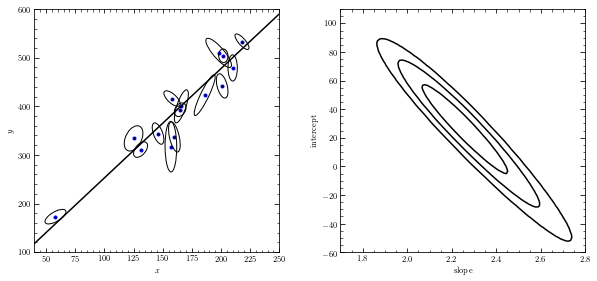

In [30]:
plot()

# 4  Regression That Is Robust to Outliers

In practice, outliers exist in just about every dataset. Thus, methods of regression must be able to account for such outliers and be robust against them.

## 4.1 Huber Loss Function

The Huber loss function is a commonly used method of diminishing the effects of outliers in regression. In particular, the loss function seeks to minimize

$$ \sum_i e(y_i|y), $$

where,

$$ e(y_i|y) = \begin{cases} 
      \frac{1}{2}t^2 & |t|\leq c \\
      c|t|-\frac{1}{2}c^2 & |t|\geq c
   \end{cases},\,\, t=\frac{y_i-y}{\Delta y_i}.$$

In [25]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


#------------------------------------------------------------
# Define the Huber loss
def Phi(t, c):
    t = abs(t)
    flag = (t > c)
    return (~flag) * (0.5 * t ** 2) - (flag) * c * (0.5 * c - t)

def plot():
    #------------------------------------------------------------
    # Plot for several values of c
    fig = plt.figure(figsize=(5*1.5, 1.5*3.75))
    ax = fig.add_subplot(111)

    x = np.linspace(-10, 10, 100)

    for c in (1, 2, 3, 5, 1000):
        y = Phi(x, c)
        ax.plot(x, y, '-k')

        if c > 10:
            s = r'\infty'
        else:
            s = str(c)

        ax.text(x[6], y[6], '$c=%s$' % s,
                ha='center', va='center',
                bbox=dict(boxstyle='round', ec='k', fc='w'))

    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$\Phi(t)$')

    plt.show()

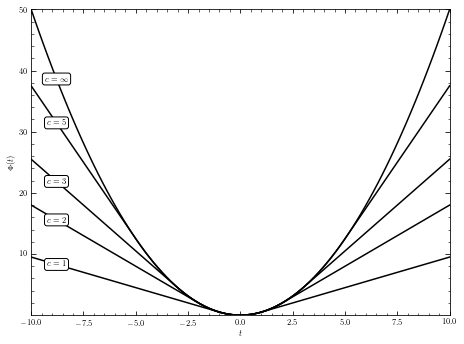

In [26]:
plot()

In [21]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from scipy import optimize
from astroML.datasets import fetch_hogg2010test

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']


# Define the standard squared-loss function
def squared_loss(m, b, x, y, dy):
    y_fit = m * x + b
    return np.sum(((y - y_fit) / dy) ** 2, -1)


# Define the log-likelihood via the Huber loss function
def huber_loss(m, b, x, y, dy, c=2):
    y_fit = m * x + b
    t = abs((y - y_fit) / dy)
    flag = t > c
    return np.sum((~flag) * (0.5 * t ** 2) - (flag) * c * (0.5 * c - t), -1)

f_squared = lambda beta: squared_loss(beta[0], beta[1], x=x, y=y, dy=dy)
f_huber = lambda beta: huber_loss(beta[0], beta[1], x=x, y=y, dy=dy, c=1)

#------------------------------------------------------------
# compute the maximum likelihood using the huber loss
beta0 = (2, 30)
beta_squared = optimize.fmin(f_squared, beta0)
beta_huber = optimize.fmin(f_huber, beta0)

print(beta_squared)
print(beta_huber)

def plot():
    #------------------------------------------------------------
    # Plot the results
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)

    x_fit = np.linspace(0, 350, 10)
    ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], '--k',
            label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))
    ax.plot(x_fit, beta_huber[0] * x_fit + beta_huber[1], '-k',
            label="Huber loss:\n $y=%.2fx + %.1f$" % tuple(beta_huber))
    ax.legend(loc=4)

    ax.errorbar(x, y, dy, fmt='.k', lw=1, ecolor='gray')

    ax.set_xlim(0, 350)
    ax.set_ylim(100, 700)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.show()

Optimization terminated successfully.
         Current function value: 289.963723
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 43.439758
         Iterations: 59
         Function evaluations: 115
[  1.07674745 213.27350923]
[ 1.96473118 70.00573832]


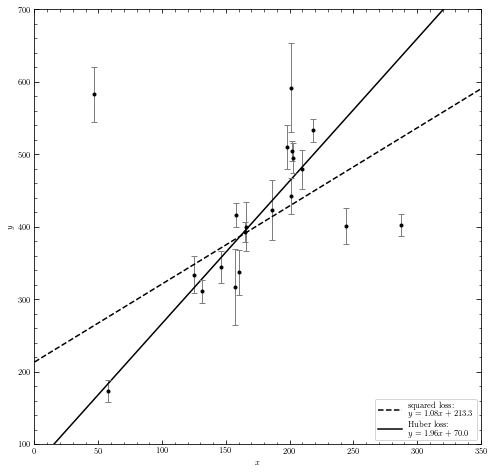

In [22]:
plot()

## 4.2 Bayesian Outlier Methods

Ideally, one could augment their model to explain outliers directly. Let's look at two different methods of this sort:

1. Mixture Model

    Here, outliers are accounted for by imposing a Gaussian background component to the data likelihood. This background is characterized by the parameters $\mu_b$, $V_b$, and $p_b$, which are the background mean, background variance, and probability that a given point is an outlier. The likelihood becomes:
    
    $$ p(\{y_i\}|\{x_i\},\{\sigma_i\},\theta_0,\theta_1,\mu_b,V_b,p_b) \propto \prod_{i=1}^{N} \left[ \frac{1-p_b}{\sqrt{2\pi\sigma_i^2}} \exp\left(-\frac{(y_i-\theta_1x_i-\theta_0)^2}{2\sigma_i^2}\right) + \frac{p_b}{\sqrt{2\pi(V_b+\sigma_i^2)}} \exp\left(-\frac{(y_i-\mu_b)^2}{2(V_b+\sigma_i^2)}\right) \right]. $$

## 4.2 Bayesian Outlier Methods

2. Nuisance Parameter Model

    In this model, the goal is to directly identify outliers. This is accomplished by fitting for nuisance parameters, $\{g_i\}$, where $g_i=1$ signifies a good data point and $g_i=0$ signifies a bad data point. The likelihood becomes:
    
    $$ p(\{y_i\}|\{x_i\},\{\sigma_i\},\{g_i\},\theta_0,\theta_1,\mu_b,V_b) \propto \prod_{i=1}^{N} \left[ \frac{g_i}{\sqrt{2\pi\sigma_i^2}} \exp\left(-\frac{(y_i-\theta_1x_i-\theta_0)^2}{2\sigma_i^2}\right) + \frac{1-g_i}{\sqrt{2\pi(V_b+\sigma_i^2)}} \exp\left(-\frac{(y_i-\mu_b)^2}{2(V_b+\sigma_i^2)}\right) \right]. $$ 
    
    For each data point, marginilizing over all parameters aside from the nuisance parameter yields a posterior estimate on whether or not this point is indeed an outlier!

In [3]:
# Author: Jake VanderPlas (adapted to PyMC3 by Brigitta Sipocz)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np

import pymc3 as pm

from matplotlib import pyplot as plt
from theano import shared as tshared
import theano.tensor as tt

from astroML.datasets import fetch_hogg2010test
from astroML.plotting.mcmc import convert_to_stdev


# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

np.random.seed(0)

# ------------------------------------------------------------
# Get data: this includes outliers. We need to convert them to Theano variables
data = fetch_hogg2010test()
xi = tshared(data['x'])
yi = tshared(data['y'])
dyi = tshared(data['sigma_y'])
size = len(data)


# ----------------------------------------------------------------------
# Define basic linear model

def model(xi, theta, intercept):
    slope = np.tan(theta)
    return slope * xi + intercept


# ----------------------------------------------------------------------
# First model: no outlier correction
with pm.Model():
    # set priors on model gradient and y-intercept
    inter = pm.Uniform('inter', -1000, 1000)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2)

    y = pm.Normal('y', mu=model(xi, theta, inter), sd=dyi, observed=yi)

    trace0 = pm.sample(draws=5000, tune=1000)


# ----------------------------------------------------------------------
# Second model: nuisance variables correcting for outliers
# This is the mixture model given in equation 17 in Hogg et al
def mixture_likelihood(yi, xi):
    """Equation 17 of Hogg 2010"""

    sigmab = tt.exp(log_sigmab)
    mu = model(xi, theta, inter)

    Vi = dyi ** 2
    Vb = sigmab ** 2

    root2pi = np.sqrt(2 * np.pi)

    L_in = (1. / root2pi / dyi * np.exp(-0.5 * (yi - mu) ** 2 / Vi))

    L_out = (1. / root2pi / np.sqrt(Vi + Vb)
             * np.exp(-0.5 * (yi - Yb) ** 2 / (Vi + Vb)))

    return tt.sum(tt.log((1 - Pb) * L_in + Pb * L_out))


with pm.Model():
    # uniform prior on Pb, the fraction of bad points
    Pb = pm.Uniform('Pb', 0, 1.0, testval=0.1)

    # uniform prior on Yb, the centroid of the outlier distribution
    Yb = pm.Uniform('Yb', -10000, 10000, testval=0)

    # uniform prior on log(sigmab), the spread of the outlier distribution
    log_sigmab = pm.Uniform('log_sigmab', -10, 10, testval=5)

    inter = pm.Uniform('inter', -200, 400)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2, testval=np.pi / 4)

    y_mixture = pm.DensityDist('mixturenormal', logp=mixture_likelihood,
                               observed={'yi': yi, 'xi': xi})

    trace1 = pm.sample(draws=5000, tune=1000)


# ----------------------------------------------------------------------
# Third model: marginalizes over the probability that each point is an outlier.
# define priors on beta = (slope, intercept)

def outlier_likelihood(yi, xi):
    """likelihood for full outlier posterior"""

    sigmab = tt.exp(log_sigmab)
    mu = model(xi, theta, inter)

    Vi = dyi ** 2
    Vb = sigmab ** 2

    logL_in = -0.5 * tt.sum(qi * (np.log(2 * np.pi * Vi)
                                  + (yi - mu) ** 2 / Vi))

    logL_out = -0.5 * tt.sum((1 - qi) * (np.log(2 * np.pi * (Vi + Vb))
                                         + (yi - Yb) ** 2 / (Vi + Vb)))

    return logL_out + logL_in


with pm.Model():
    # uniform prior on Pb, the fraction of bad points
    Pb = pm.Uniform('Pb', 0, 1.0, testval=0.1)

    # uniform prior on Yb, the centroid of the outlier distribution
    Yb = pm.Uniform('Yb', -10000, 10000, testval=0)

    # uniform prior on log(sigmab), the spread of the outlier distribution
    log_sigmab = pm.Uniform('log_sigmab', -10, 10, testval=5)

    inter = pm.Uniform('inter', -1000, 1000)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2)

    # qi is bernoulli distributed
    qi = pm.Bernoulli('qi', p=1 - Pb, shape=size)

    y_outlier = pm.DensityDist('outliernormal', logp=outlier_likelihood,
                               observed={'yi': yi, 'xi': xi})

    trace2 = pm.sample(draws=5000, tune=1000)

def plot():
    # ------------------------------------------------------------
    # plot the data
    fig = plt.figure(figsize=(7, ))
    fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                        bottom=0.1, top=0.95, hspace=0.2)

    # first axes: plot the data
    ax1 = fig.add_subplot(221)
    ax1.errorbar(data['x'], data['y'], data['sigma_y'], fmt='.k', ecolor='gray', lw=1)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')

    #------------------------------------------------------------
    # Go through models; compute and plot likelihoods
    linestyles = [':', '--', '-']
    labels = ['no outlier correction\n(dotted fit)',
              'mixture model\n(dashed fit)',
              'outlier rejection\n(solid fit)']

    x = np.linspace(0, 350, 10)

    bins = [(np.linspace(140, 300, 51), np.linspace(0.6, 1.6, 51)),
            (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51)),
            (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51))]

    for i, trace in enumerate([trace0, trace1, trace2]):
        H2D, bins1, bins2 = np.histogram2d(np.tan(trace['theta']),
                                           trace['inter'], bins=50)
        w = np.where(H2D == H2D.max())

        # choose the maximum posterior slope and intercept
        slope_best = bins1[w[0][0]]
        intercept_best = bins2[w[1][0]]

        # plot the best-fit line
        ax1.plot(x, intercept_best + slope_best * x, linestyles[i], c='k')

        # For the model which identifies bad points,
        # plot circles around points identified as outliers.
        if i == 2:
            Pi = trace['qi'].mean(0)
            outlier_x = data['x'][Pi < 0.32]
            outlier_y = data['y'][Pi < 0.32]
            ax1.scatter(outlier_x, outlier_y, lw=1, s=400, alpha=0.5,
                        facecolors='none', edgecolors='red')

        # plot the likelihood contours
        ax = plt.subplot(222 + i)

        H, xbins, ybins = np.histogram2d(trace['inter'],
                                         np.tan(trace['theta']), bins=bins[i])
        H[H == 0] = 1E-16
        Nsigma = convert_to_stdev(np.log(H))

        ax.contour(0.5 * (xbins[1:] + xbins[:-1]),
                   0.5 * (ybins[1:] + ybins[:-1]),
                   Nsigma.T, levels=[0.683, 0.955], colors='black')

        ax.set_xlabel('intercept')
        ax.set_ylabel('slope')
        ax.grid(color='gray')
        ax.xaxis.set_major_locator(plt.MultipleLocator(40))
        ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))

        ax.text(0.96, 0.96, labels[i], ha='right', va='top',
                bbox=dict(fc='w', ec='none', alpha=0.5),
                transform=ax.transAxes)
        ax.set_xlim(bins[i][0][0], bins[i][0][-1])
        ax.set_ylim(bins[i][1][0], bins[i][1][-1])

    ax1.set_xlim(0, 350)
    ax1.set_ylim(100, 700)

    plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, inter]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [00:07<00:00, 1648.89draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, inter, log_sigmab, Yb, Pb]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [00:20<00:00, 586.34draws/s]
The acceptance probability does not match the target. It is 0.9339332045890413, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [theta, inter, log_sigmab, Yb, Pb]
>BinaryGibbsMetropolis: [qi]
Sampling 2 chains, 63 divergences: 100%|██████████| 12000/12000 [00:29<00:00, 411.45draws/

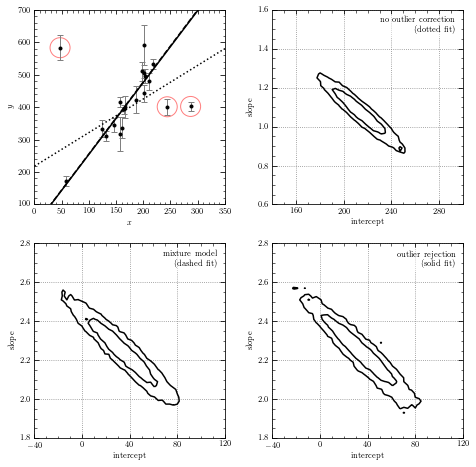

In [4]:
plot()

### Which Method Should I Use?

Here's a table from the book:
![alt](lecture13_files/Table8p1.png)